## Pipeline

imblearn 라이브러리에서 파이프라인(Pipeline)은 데이터 전처리 → 샘플링 → 모델 학습 과정을 한 번에 연결해서 처리할 수 있는 기능

- 전처리 단계: StandardScaler, MinMaxScaler 등 데이터 스케일링
- 샘플링 단계: SMOTE, RandomUnderSampler, ADASYN, SMOTEENN 등
- 모델 학습 단계: RandomForestClassifier, LogisticRegression 등

In [6]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter

# 1. 불균형 데이터셋 생성
X, y = make_classification(
    n_classes=2, class_sep=2,
    weights=[0.9, 0.1], # 불균형 데이터 비율
    n_informative=3, n_redundant=1,
    n_features=10, n_clusters_per_class=1,
    n_samples=1000, random_state=42
)

print(f"Original dataset shape: {Counter(y)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. 파이프라인 구성
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

# 3. 모델 학습
pipeline.fit(X_train, y_train)

# 4. 평가
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


Original dataset shape: Counter({0: 892, 1: 108})
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       263
           1       0.97      1.00      0.99        37

    accuracy                           1.00       300
   macro avg       0.99      1.00      0.99       300
weighted avg       1.00      1.00      1.00       300



## 다중 분류 : 로지스틱회귀

In [7]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter

# 1. 불균형 다중 클래스 데이터셋 생성
X, y = make_classification(
    n_classes=3, class_sep=2,
    weights=[0.7, 0.2, 0.1],  # 클래스 비율 7:2:1
    n_informative=5, n_redundant=2,
    n_features=12, n_clusters_per_class=1,
    n_samples=1500, random_state=42
)

print(f"Original dataset shape: {Counter(y)}")

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. 파이프라인 구성
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42))
])

# 3. 모델 학습
pipeline.fit(X_train, y_train)

# 4. 평가
y_pred = pipeline.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))


Original dataset shape: Counter({0: 1045, 1: 304, 2: 151})

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       314
           1       0.99      0.97      0.98        91
           2       0.91      0.96      0.93        45

    accuracy                           0.98       450
   macro avg       0.96      0.97      0.97       450
weighted avg       0.98      0.98      0.98       450



C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### 세 가지 파이프라인(기본, SMOTE, SMOTEENN)의 Precision / Recall / F1 막대그래프를 표시

=== 모델별 성능 비교 ===
                    Model  Precision    Recall        F1  Accuracy
0  Baseline (No Sampling)   0.934066  0.825243  0.876289     0.976
1                   SMOTE   0.716535  0.883495  0.791304     0.952
2                SMOTEENN   0.715385  0.902913  0.798283     0.953


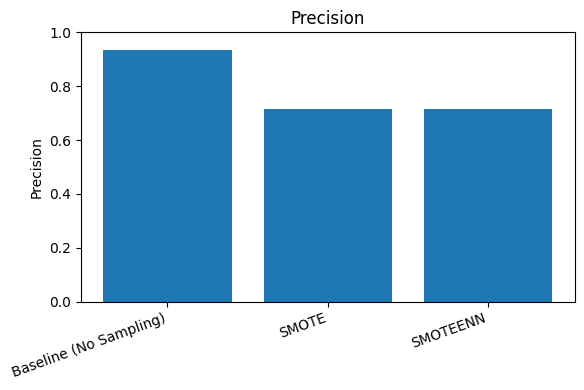

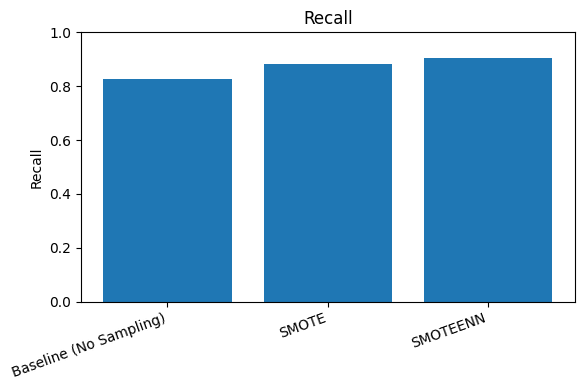

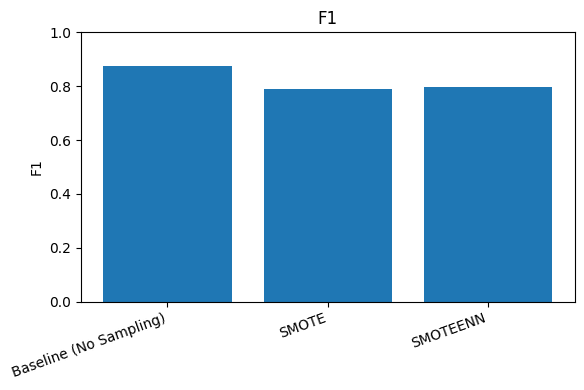

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# 1) 불균형 데이터셋 생성
X, y = make_classification(
    n_samples=4000,
    n_features=20,
    n_informative=6,
    n_redundant=4,
    n_classes=2,
    weights=[0.9, 0.1],  # 불균형 비율 설정
    class_sep=1.5,
    random_state=42,
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 2) 세 가지 파이프라인 정의
clf = LogisticRegression(max_iter=1000, random_state=42)

pipelines = {
    "Baseline (No Sampling)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", clf),
    ]),
    "SMOTE": Pipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("clf", clf),
    ]),
    "SMOTEENN": Pipeline([
        ("scaler", StandardScaler()),
        ("smoteenn", SMOTEENN(random_state=42)),
        ("clf", clf),
    ]),
}

# 3) 학습 및 평가
records = []
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )
    acc = accuracy_score(y_test, y_pred)
    records.append({
        "Model": name,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Accuracy": acc,
    })

df = pd.DataFrame(records).sort_values("Model").reset_index(drop=True)

# 4) 결과 저장
df.to_csv("imblearn_pipeline_comparison.csv", index=False)
print("=== 모델별 성능 비교 ===")
print(df)

# 5) Precision, Recall, F1 시각화
metrics = ["Precision", "Recall", "F1"]
for metric in metrics:
    plt.figure(figsize=(6, 4))
    plt.bar(df["Model"], df[metric])
    plt.title(metric)
    plt.ylabel(metric)
    plt.xticks(rotation=20, ha="right")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
